# Использование Cycle GAN для смены стиля изображений

## Генеративно-состязательная сеть - GAN
**Сеть GAN(Generative adversarial network)** - алгоритм машинного обучения **без учителя**, построенный на комбинации из двух видов сетей:
- **сети генератора (G)**, которая генерирует новые образцы исходя из переданных на вход данных
- **сети дискриминатора (D)**, которая старается отличить правильные, реальные образцы, получаенные ему на вход, от неправильных, созданных генератором

Посредством ряда циклов генерации и дискриминации обе сети обучают друг друга, генератор пытается обмануть дискриминатор, а тот в свою очередь пытается определить, что данные сгенерированные. Довольно часто такие сети сравнивают с творцом и критиком, фальшивомонетчиком и купюроприемщиком.

Впервые такие сети были представлены в работе *Яна Гудфеллоу*, *Йошуа Бенжио* и *Аарона Курвиля* в 2014 году. Оригинальная архитектура GAN-сетей выглядит следующим образом:

<img src="./presentation_imgs/Арх_ган.png" width="80%">

## Принцип обучения сети GAN
1. сеть генератора никогда *не видела никакого реального изображения*, но пытается создать изображение, которые выглядит как реальное;
2. сеть дискриминатора пытается определить, является ли изобрежние реальным или оно поддельное;
3. генератор пытается обмануть дискриминатор, создавая всё более реалистичные изображения с каждой итерацией;
4. дискриминатор совершенствует критерий определения подделки;
5. посредством обратной связи обе сети получают положительные изменения;
4. в конечном итоге дискриминатор обучает генератор до стадии в которой уже не может больше отличить реальное изображение от подделки, сеть достигает состояния равновесия и считается обученной.

## Равновесие Нэша
**Равновесие Нэша** описывает состояние в тории игр, когда несколько игроков пытаются выбрать наилучшую возможную стратегию для себя, чтобы получить наилучший возможный релультат, исходя из своего ожидания что будут делать другие игроки. В конце концов все игроки достигают состояния, когда выбрана наилучшая стратегия для каждого. В данном состоянии они не получают никакой выгоды от изменения своей стратегии. Такое состояние и называется равновесием Нэша.

## Cycle GAN
**Cycle GAN** относится к типу порождающей состязательной сети, предназначена для междоменного преобразования задач (изменения стиля изображения, превращение картин в фотографии и фотографий в картины)

Данная сеть была представлена *Цзюнь-Янь Чжу*, *Тэсуном Парком*, *Филиппом Изолой* и *Алексеем А. Эфросом* в работе **"Непарный перевод изображения в изображение с использованием согласованных по циклу состязательных сетей"**, выполненная в феврале 2018 года.

В данной архитектуре обучаются 2 генератора и 2 дискриминатора:
1. **генератор А** обучает отображение $$G:X \rightarrow Y$$где X - исходный домен и Y - целевой домен. Он преобразует изображение из домена А в изображение из домена B.
2. **генератор B** обучает отображение $$F:Y \rightarrow X$$где Y - исходный домен и X - целевой домен. Он преобразует изображение из домена B в изображение из домена A.
3. **дискриминатор А** учится различать изображение из домена A и сгенерированные изображения.
3. **дискриминатор B** учится различать изображение из домена B и сгенерированные изображения.

<img src="./presentation_imgs/cycleGAN.png" width="40%">

### Целевая функция
Функция потерь для данной состязательной сети является взвешенной суммой следующий потерь:
1. состязательные потери (генераторы обучаются создавать правдоподобные изображения, а дискриминаторы их отличиать от оргинальных)
2. потери согласованного цикла (для уменьшения вариантов функций отображений для одного изображения)

#### Виды нормализаций
![Виды нормализаций](gn.png)
<div style="text-align: center;">https://www.tensorflow.org/addons/tutorials/layers_normalizations?hl=IT#install_tensorflow_20_and_tensorflow-addons</div>

### Архитектура генератора
<img src="generator.png" width="70%">

### Архитектура дискриминатора
<img src="discriminator.png" width="70%">

### Архитектура состязательной сети
<img src="adv_model.png">

### Источники
1. Ахирвар К. Состязательные сети. Проекты / пер. с анг. В.А.Яроцкого. 2020. - 252 с.

In [1]:
import glob
import time

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import Input
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.layers import BatchNormalization, LeakyReLU, Dense, Flatten, Activation
from tensorflow.keras.layers import Conv2D, UpSampling2D, Reshape, MaxPooling2D, Add, Conv2DTranspose, ZeroPadding2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam

from tensorflow_addons.layers import InstanceNormalization

from scipy.misc import imread, imresize, imsave
from tensorflow.keras.utils import plot_model

/usr/local/lib/python3.7/dist-packages/tensorflow_addons-0.12.0.dev0-py3.7-linux-x86_64.egg/tensorflow_addons/utils/ensure_tf_install.py:43: UserWarning: You are currently using a nightly version of TensorFlow (2.5.0-dev20201207). 
TensorFlow Addons offers no support for the nightly versions of TensorFlow. Some things might work, some other might not. 
If you encounter a bug, do not file an issue on GitHub.
  UserWarning,


In [2]:
human_path = "../datasets/celeba/img_align_celeba/*.*"
anime_path = "../datasets/portraits/*.*"
all_human_images = glob.glob(human_path)
all_anime_images = glob.glob(anime_path)
print(len(all_human_images))
print(len(all_anime_images))

def sample_human_images(batch_size, resolution_shape):    
    images_batch = np.random.choice(all_human_images, size=batch_size)

    images = []

    for img in images_batch:
        img1 = imread(img, mode='RGB')
        img1 = img1.astype(np.float32)

        img1_reshaped = imresize(img1, resolution_shape) / 255.0

        images.append(img1_reshaped)

    return np.array(images)

def sample_anime_images(batch_size, resolution_shape):
    images_batch = np.random.choice(all_anime_images, size=batch_size)

    images = []

    for img in images_batch:
        img1 = imread(img, mode='RGB')
        img1 = img1.astype(np.float32)

        img1_reshaped = imresize(img1, resolution_shape) / 255.0

        images.append(img1_reshaped)

    return np.array(images)

def save_images(original_imageA, original_imageB, generated_imageA, generated_imageB, path):
    fig = plt.figure()
    ax = fig.add_subplot(1, 4, 1)
    ax.imshow(original_imageA)
    ax.axis("off")
    ax.set_title("Original A")

    ax = fig.add_subplot(1, 4, 2)
    ax.imshow(generated_imageB)
    ax.axis("off")
    ax.set_title("Generated B")

    ax = fig.add_subplot(1, 4, 3)
    ax.imshow(original_imageB)
    ax.axis("off")
    ax.set_title("Original B")
    
    ax = fig.add_subplot(1, 4, 4)
    ax.imshow(generated_imageA)
    ax.axis("off")
    ax.set_title("Generated A")

    plt.savefig(path)

202599
302652


/home/olaf/.local/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
  
/home/olaf/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
/home/olaf/.local/lib/python3.7/site-packages/ipykernel_launcher.py:29: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
/home/olaf/.local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.


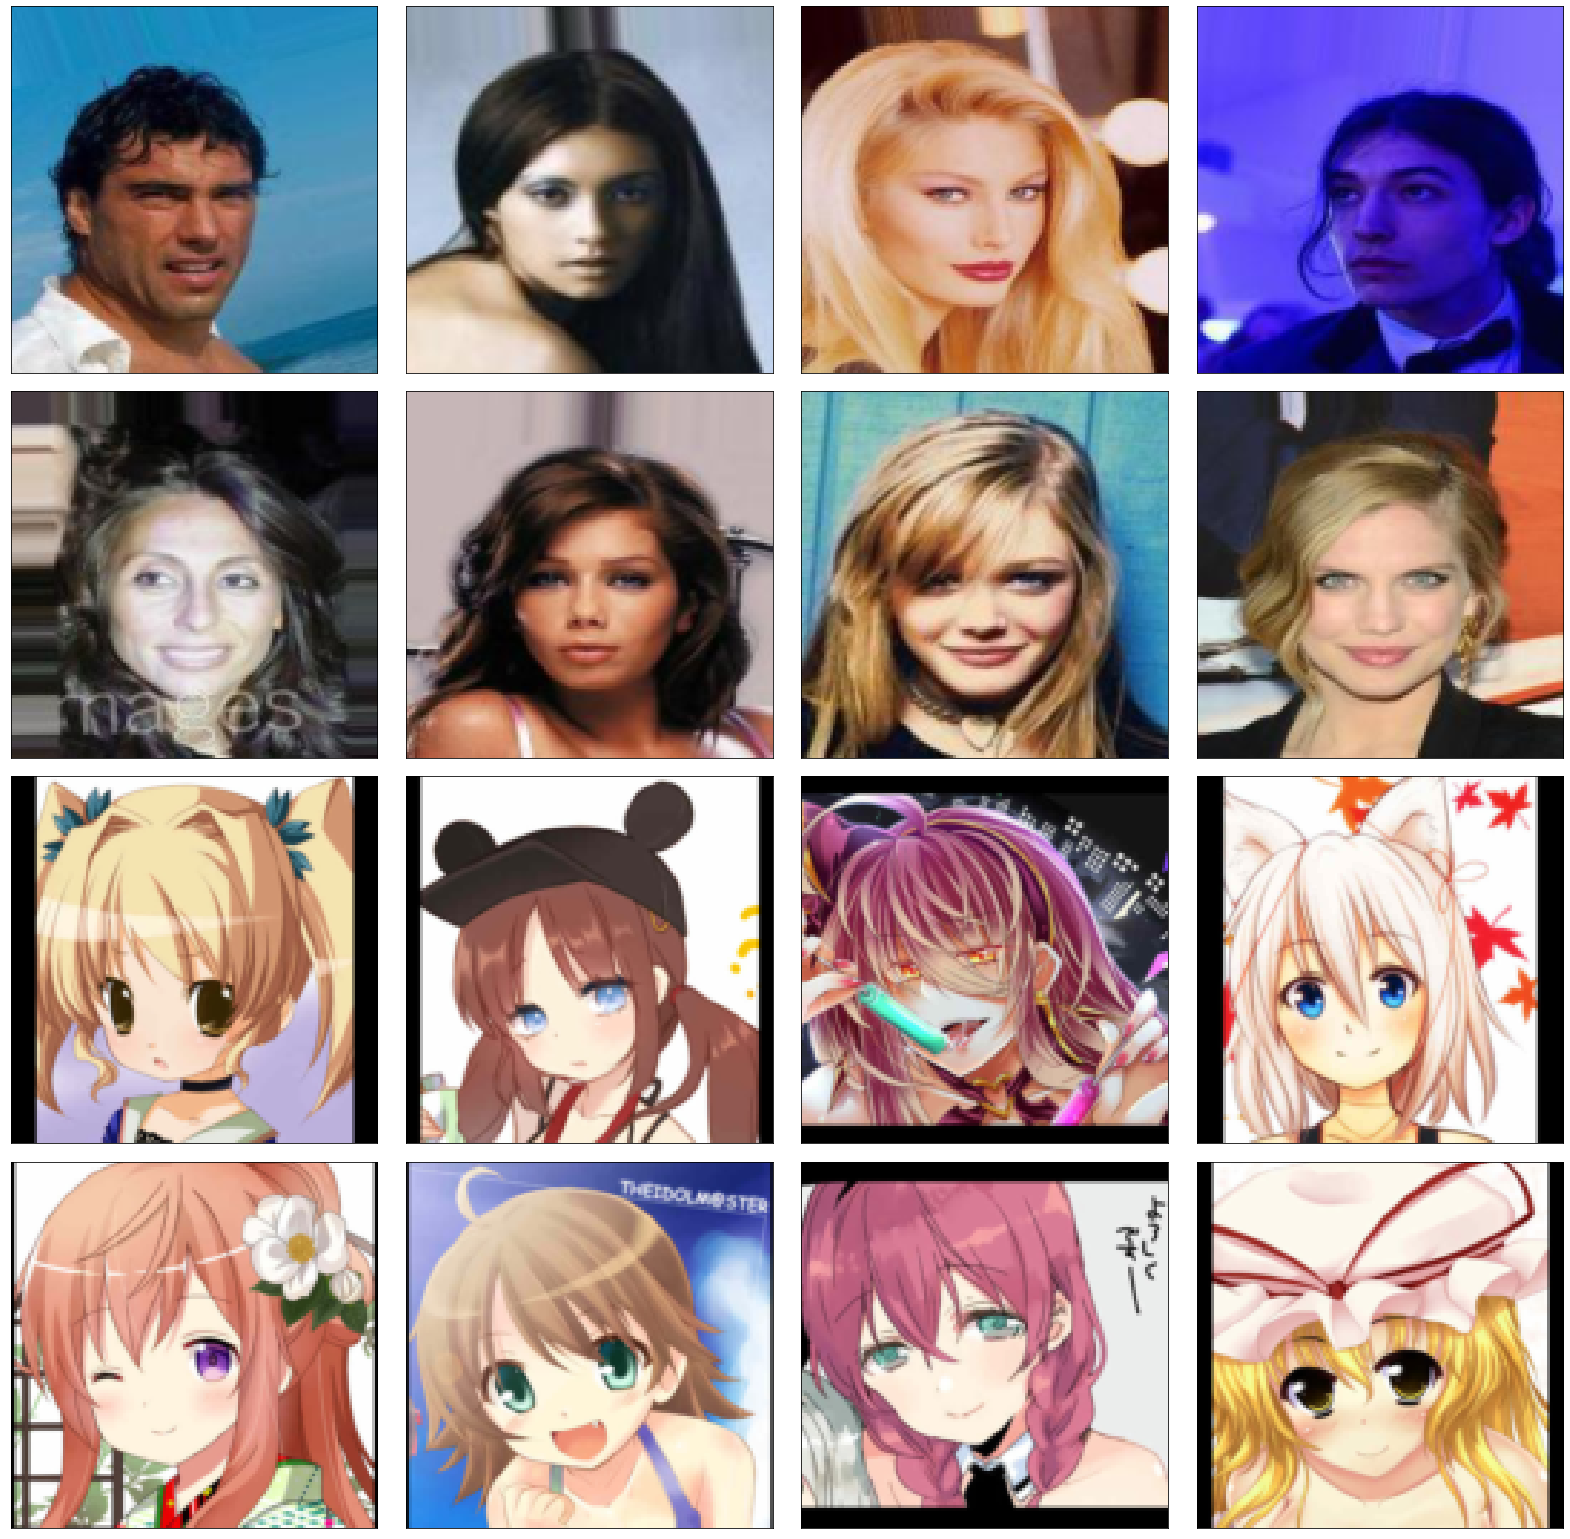

In [3]:
version = 2
image_shape = (128, 128, 3)

tmp_data_humans = sample_human_images(8, image_shape)
tmp_data_anime = sample_anime_images(8, image_shape)

fig, axes = plt.subplots(4, 4, figsize=(28, 28),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.05, wspace=0.05))

for i, ax in enumerate(axes.flat):
    if i<8:
        ax.imshow(tmp_data_humans[i], interpolation='nearest')
    else:
        ax.imshow(tmp_data_anime[i-8], interpolation='nearest')

In [4]:
residual_blocks=6
hidden_layers = 3

def residual_block(x):
    res = Conv2D(128, (3,3), strides=1, padding="same")(x)
    res = BatchNormalization(axis=3, momentum=0.9, epsilon=1e-5)(res)
    res = Activation('relu')(res)
    res = Conv2D(128, (3,3), strides=1, padding="same")(res)
    res = BatchNormalization(axis=3, momentum=0.9, epsilon=1e-5)(res)
    
    return Add()([res, x])

def get_generator():
    input_layer = Input(image_shape)
    x = Conv2D(32, (7,7), strides=1, padding="same")(input_layer)
    x = InstanceNormalization(axis=1)(x)
    x = Activation("relu")(x)
    
    x = Conv2D(64, (3,3), strides=2, padding="same")(x)
    x = InstanceNormalization(axis=1)(x)
    x = Activation("relu")(x)
    
    x = Conv2D(128, (3,3), strides=2, padding="same")(x)
    x = InstanceNormalization(axis=1)(x)
    x = Activation("relu")(x)
    
    for _ in range(residual_blocks):
        x = residual_block(x)
        
    x = Conv2DTranspose(64, (3,3), strides=2, padding="same", use_bias=False)(x)
    x = InstanceNormalization(axis=1)(x)
    x = Activation("relu")(x)
    
    x = Conv2DTranspose(64, (3,3), strides=2, padding="same", use_bias=False)(x)
    x = InstanceNormalization(axis=1)(x)
    x = Activation("relu")(x)
    
    x = Conv2D(3, (7,7), strides=1, padding="same")(x)
    output = Activation("sigmoid")(x)
    
    model = Model(inputs=[input_layer], outputs=[output])
    return model

def get_discriminator():
    input_layer = Input(image_shape)
    x = ZeroPadding2D(padding=(1,1))(input_layer)
    
    x = Conv2D(64, (4,4), strides=2, padding="valid")(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    x = ZeroPadding2D(padding=(1,1))(x)
    
    for i in range(1, hidden_layers+1):
        x = Conv2D(2**i * 64, (4,4), strides=2, padding="valid")(x)
        x = InstanceNormalization(axis=1)(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = ZeroPadding2D(padding=(1,1))(x)
        
    output = Conv2D(1, (4,4), strides=1, activation="sigmoid")(x)
    
    model = Model(inputs=[input_layer], outputs=[output])
    return model

In [5]:
generatorA = get_generator()
generatorB = get_generator()
# plot_model(generatorA, to_file='generator.png', show_shapes=True)

In [6]:
discriminatorA = get_discriminator()
discriminatorB = get_discriminator()
# plot_model(discriminatorA, to_file='discriminator.png', show_shapes=True)

In [7]:
common_optimizer = Adam(0.0002, 0.5)

discriminatorA.compile(loss="mse", optimizer = common_optimizer, metrics=["accuracy"])
discriminatorB.compile(loss="mse", optimizer = common_optimizer, metrics=["accuracy"])

## Функции рассчёта ошибок
- MAE (Mean Absolute Error) - среднее значение абсолютных разностей
- MSE (Mean Squared Error) - среднее значение квадратов разностей

In [8]:
inputA = Input(image_shape)
inputB = Input(image_shape)

generatedB = generatorA(inputA)
generatedA = generatorB(inputB)

reconctructedA = generatorB(generatedB)
reconctructedB = generatorA(generatedA)

generatedAId = generatorB(inputA)
generatedBId = generatorA(inputB)

discriminatorA.trainable = False
discriminatorB.trainable = False

probsA = discriminatorA(generatedA)
probsB = discriminatorB(generatedB)

adv_model = Model(inputs=[inputA, inputB], outputs=[probsA, probsB, reconctructedA, reconctructedB, generatedAId, generatedBId])
adv_model.compile(loss=["mse", "mse", "mae", "mae", "mae", "mae"], loss_weights=[1, 1, 10.0, 10.0, 1.0, 1.0], optimizer=common_optimizer, metrics=["accuracy"])

# plot_model(adv_model, to_file='adv_model.png', show_shapes=True)

In [9]:
summary_writer= tf.summary.create_file_writer("logs/v_{}".format(version))

In [ ]:
start_epoch = 1041
epochs = 10000
batch_size = 12
epoch_steps = 10

real_labels = np.ones((batch_size, 7, 7, 1))
fake_labels = np.zeros((batch_size, 7, 7, 1))

generatorA.load_weights("weights/v_2_epoch_1040_genA.h5")
generatorB.load_weights("weights/v_2_epoch_1040_genB.h5")
discriminatorA.load_weights("weights/v_2_epoch_1040_disA.h5")
discriminatorB.load_weights("weights/v_2_epoch_1040_disB.h5")

for epoch in range(start_epoch, epochs):
    
    d_loss = 0
    g_loss = 0
    
    d_acc = 0
    g_acc = 0
    
    for index in range(epoch_steps):
        """ обучение дискриминатора """
        batchA = sample_human_images(batch_size, image_shape)
        batchB = sample_anime_images(batch_size, image_shape)
        
        generatedB = generatorA.predict_on_batch(batchA)
        generatedA = generatorB.predict_on_batch(batchB)
        
        d_A_Loss1, d_A_Accuracy1 = discriminatorA.train_on_batch(batchA, real_labels)
        d_A_Loss2, d_A_Accuracy2 = discriminatorA.train_on_batch(generatedA, fake_labels)
        
        d_B_Loss1, d_B_Accuracy1 = discriminatorB.train_on_batch(batchB, real_labels)
        d_B_Loss2, d_B_Accuracy2  = discriminatorB.train_on_batch(generatedB, fake_labels)
        
#         print(discriminatorA.metrics_names, dALoss1)
        d_loss += ((d_A_Loss1+d_A_Loss2)/2.0 + (d_B_Loss1+d_B_Loss2)/2.0)/2.0
        d_acc += ((d_A_Accuracy1+d_A_Accuracy2)/2.0 + (d_B_Accuracy1+d_B_Accuracy2)/2.0)/2.0
        
        """ обучение генертора """
        loss, _, _, g_A_Loss, g_B_Loss, _, _, _, _, g_A_Accuracy, g_B_Accuracy, _, _ = adv_model.train_on_batch([batchA, batchB], [real_labels, real_labels, batchA, batchB, batchA, batchB])
        
#         print(adv_model.metrics_names, g_loss1)
        g_loss += (g_A_Loss + g_B_Loss)/2.0
        g_acc += (g_A_Accuracy + g_B_Accuracy)/2.0
    
    with summary_writer.as_default():
        tf.summary.scalar('d_loss', d_loss/epoch_steps, epoch)
        tf.summary.scalar('g_loss', g_loss/epoch_steps, epoch)
        tf.summary.scalar('d_accuracy', d_acc/epoch_steps, epoch)
        tf.summary.scalar('g_accuracy', g_acc/epoch_steps, epoch)
    summary_writer.flush()
    
    if epoch%5 == 0:        
        batchA = sample_human_images(1, image_shape)
        batchB = sample_anime_images(1, image_shape)
        gen_imageB = generatorA.predict_on_batch(batchA)
        gen_imageA = generatorB.predict_on_batch(batchB)        
        save_images(batchA[0], batchB[0], gen_imageA[0], gen_imageB[0], "images/v_{}_epoch_{}.png".format(version, epoch))
        
    if epoch%20 == 0:
        generatorA.save_weights("weights/v_{}_epoch_{}_genA.h5".format(version, epoch))
        discriminatorA.save_weights("weights/v_{}_epoch_{}_disA.h5".format(version, epoch))
        generatorB.save_weights("weights/v_{}_epoch_{}_genB.h5".format(version, epoch))
        discriminatorB.save_weights("weights/v_{}_epoch_{}_disB.h5".format(version, epoch))

/home/olaf/.local/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
  
/home/olaf/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
/home/olaf/.local/lib/python3.7/site-packages/ipykernel_launcher.py:29: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
/home/olaf/.local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.


In [ ]:
# generatorA.load_weights("weights/v_2_epoch_1040_genA.h5")
# generatorB.load_weights("weights/v_2_epoch_1040_genB.h5")

# generatorA.load_weights("weights/v_2_epoch_880_genA.h5")
# generatorB.load_weights("weights/v_2_epoch_880_genB.h5")

# generatorA.load_weights("weights/v_2_epoch_940_genA.h5")
# generatorB.load_weights("weights/v_2_epoch_940_genB.h5")

generatorA.load_weights("weights/v_2_epoch_920_genA.h5")
generatorB.load_weights("weights/v_2_epoch_920_genB.h5")

tmp_data_humans = sample_human_images(8, image_shape)

gen_images = generatorA.predict_on_batch(tmp_data_humans)
# rec_images = generatorB.predict_on_batch(gen_images)

fig, axes = plt.subplots(4, 4, figsize=(28, 28),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.05, wspace=0.05))

# for i, ax in enumerate(axes.flat):
#     if i%3==0:
#         ax.imshow(tmp_data_humans[i//3], interpolation='nearest')
#     elif i%3==1:
#         ax.imshow(gen_images[i//3], interpolation='nearest')
#     else:
#         ax.imshow(rec_images[i//3], interpolation='nearest')

for i, ax in enumerate(axes.flat):
    if i%2==0:
        ax.imshow(tmp_data_humans[i//2], interpolation='nearest')
    else:
        ax.imshow(gen_images[i//2], interpolation='nearest')